In [1]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import klaprevised as klap
from torchvision import datasets, transforms
from torch.nn.functional import one_hot
import time

# Configure datasets
train_set = datasets.MNIST('~/data/mnist', train=True)
test_set = datasets.MNIST('~/data/mnist', train=False)

In [2]:
# Data normalization
n_train = len(train_set)
n_test = len(test_set)

x_train = train_set.data.view(n_train, 28*28).numpy().astype(float)
mean = np.mean(x_train, axis=0, keepdims=True)
std = np.std(x_train, axis=0, keepdims=True)
d_eff = np.sum(std > 0)
std[std==0] = 1
x_train -= mean
x_train /= std

y_train = one_hot(train_set.targets).numpy().astype(float)

x_test = test_set.data.view(n_test, 28*28).numpy().astype(float)
x_test -= mean
x_test /= std

y_test = test_set.targets.numpy()

In [7]:
sigma = np.sqrt(d_eff)
k = 20
ind = 10000
p = 300

sigmas = [.1 * sigma, .5*sigma, sigma, 2*sigma, 5*sigma, 10*sigma]
accuracy = np.zeros((len(sigmas), 2))
times = np.zeros((len(sigmas), 2))

for i, sigma in enumerate(sigmas):
    # kernel = ExponentialKernel(sigma=sigma)
    kernel = klap.GaussianKernel(sigma=sigma)
    kernel2 = klap.KernelLaplacian
    for j in range(2):
        t = time.time()
        if j == 0:
            kernel.fit(x_train[:ind], p=p, k=k, L_reg=1e-14, R_reg=0, inverse_L=True)
        else:
            kernel.fit_with_graph_laplacian(kernel.kernel, x_train[:ind], p=p, k=k, L_reg=0, R_reg=0, inverse_L=True)
        times[i, j] = time.time() - t

        phi_train = kernel.features_map(x_train)
        mean = phi_train.mean(axis=0, keepdims=True)
        std = phi_train.std(axis=0, keepdims=True)
        std[std==0] = 1
        phi_train -= mean
        phi_train /= std
        phi_test = kernel.features_map(x_test)
        phi_test -= mean
        phi_test /= std

        A = phi_train.T @ phi_train
        A += 1e-13 * np.eye(k)
        b = phi_train.T @ y_train
        beta = np.linalg.solve(A, b)

        y_pred = (phi_test @ beta).argmax(axis=1)
        accuracy[i, j] = np.mean(y_pred == y_test)

INFO:klap:Matrix is not sdp.
INFO:klap:Setting regularizer to 1.000e-14
INFO:klap:Matrix is not sdp.
INFO:klap:Setting regularizer to 1.000e-14
INFO:klap:Matrix is not sdp.
INFO:klap:Setting regularizer to 1.000e-14


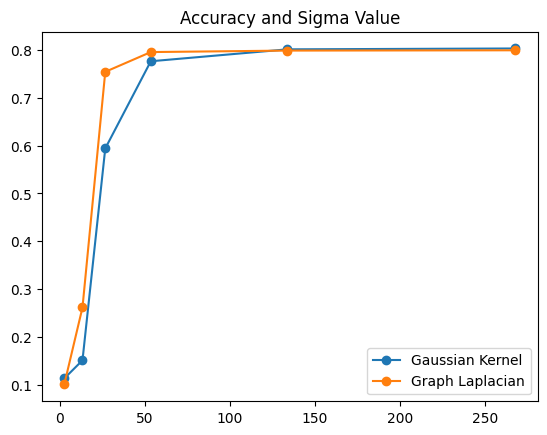

In [8]:
plt.plot(sigmas, accuracy[:, 0], marker='o', label='Gaussian Kernel')
plt.plot(sigmas, accuracy[:, 1], marker='o', label='Graph Laplacian')
plt.title('Accuracy and Sigma Value')
plt.legend()

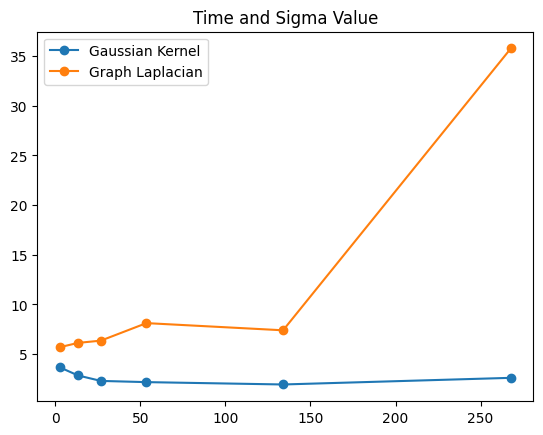

In [9]:
plt.plot(sigmas, times[:, 0], marker='o', label='Gaussian Kernel')
plt.plot(sigmas, times[:, 1], marker='o', label='Graph Laplacian')
plt.title('Time and Sigma Value')
plt.legend()